In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sionna
import scipy
from mpl_toolkits.mplot3d import Axes3D

In [2]:
FC = 8e9
BW = 20e6
D_BY_LAMBDA = 0.5
N_TX = 50
N_RX = 10
N_ROWS = 10
N_COLS = 5
N_ROWS_RX = 1
N_COLS_RX = 1
PI = np.pi
# TX_LOC = [41,4,19]
TX_LOC = [41,8,49]
RX0_LOC = [-291,60, 3]
RX1_LOC = [50,56, 3]
RX2_LOC = [-25,56, 3]
RX3_LOC = [-200,0, 3]
RX4_LOC = [-245,-52, 3]
RX5_LOC = [62,-52, 3]
RX6_LOC = [0,-10, 3]
RX7_LOC = [-134,97, 3]
RX8_LOC = [183,-131, 3]
RX9_LOC = [-1, 123, 3]

rx_pos = [RX0_LOC, RX1_LOC, RX2_LOC, RX3_LOC, RX4_LOC, \
          RX5_LOC, RX6_LOC, RX7_LOC, RX8_LOC, RX9_LOC]

def find_thresh(arr, N):

    if N <= 0:
        return np.max(arr) + 1
    if N >= arr.size:
        return np.min(arr)
    
    sorted_arr = np.sort(arr)[::-1]
    threshold = sorted_arr[N-1]
    
    return threshold

def create_e(n, delta, omega):
    e = np.empty((n,), dtype = np.complex64)
    for i in range(n):
        e[i] = np.exp(-1j*2*PI*delta*omega*i)
    return e * 1 / np.sqrt(n)

def create_U_P2P(n, delta):
    U = []
    for i in range(n):
        U.append(create_e(n, delta, i / (n * delta)))
    return np.array(U)

scene = sionna.rt.load_scene(sionna.rt.scene.etoile)
scene.frequency = FC

In [3]:
scene.tx_array = sionna.rt.PlanarArray(num_rows=N_ROWS,
                             num_cols=N_COLS,
                             vertical_spacing=D_BY_LAMBDA,
                             horizontal_spacing=D_BY_LAMBDA,
                             pattern="dipole",
                             polarization="V")
#tr38901

scene.rx_array = sionna.rt.PlanarArray(num_rows=N_ROWS_RX,
                             num_cols=N_COLS_RX,
                             vertical_spacing=D_BY_LAMBDA,
                             horizontal_spacing=D_BY_LAMBDA,
                             pattern="dipole",
                             polarization="V")

tx = sionna.rt.Transmitter(name="tx",
                 position=TX_LOC,
                 display_radius=2)

scene.add(tx)

for i in range(N_RX):
    scene.remove(f"rx-{i}")
    rx = sionna.rt.Receiver(name = f"rx-{i}",
                            position = rx_pos[i],
                            display_radius =2)
    scene.add(rx)

# rx = sionna.rt.Receiver(name="rx",
#               position=RX7_LOC,
#               display_radius=2)

# scene.add(rx)

# tx.look_at(rx)

In [4]:
p_solver  = sionna.rt.PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=5,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=True,
                 seed=41)

Bitmap[
  pixel_format = rgba,
  component_format = uint8,
  size = [655, 500],
  srgb_gamma = 1,
  struct = Struct<4>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
    uint8 A; // @3, normalized, alpha
  ],
  data = [ 1.25 MiB of image data ]
]

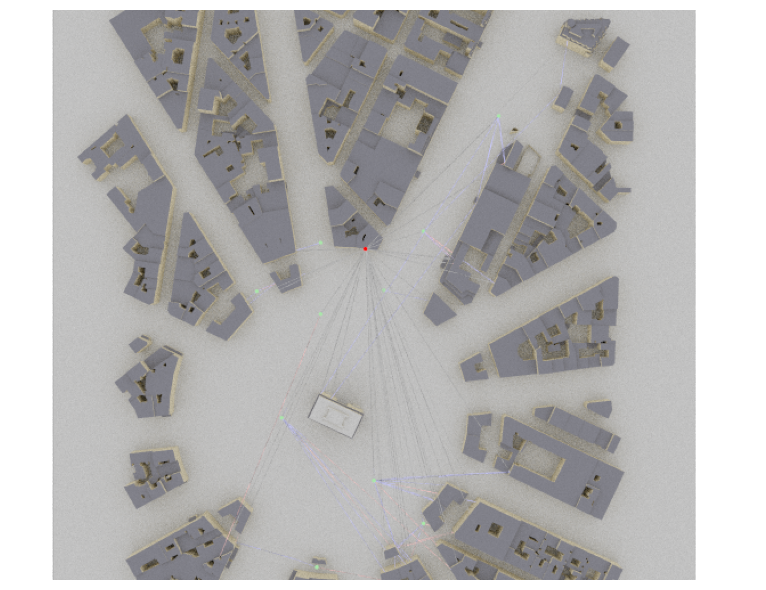

In [5]:
# scene.preview(paths=paths, clip_at=20)
# x is approx up-down, y is approx left-right
bird_cam = sionna.rt.Camera(position = [-5,-10,950], look_at = [-5,-10,0])
scene.render(camera = bird_cam, paths = paths, num_samples = 64)
scene.render_to_file(camera = bird_cam, filename="mu_mimo.png", paths = paths, num_samples = 64)

Text(0.5, 1.0, 'User Locations in Z = 3 Plane')

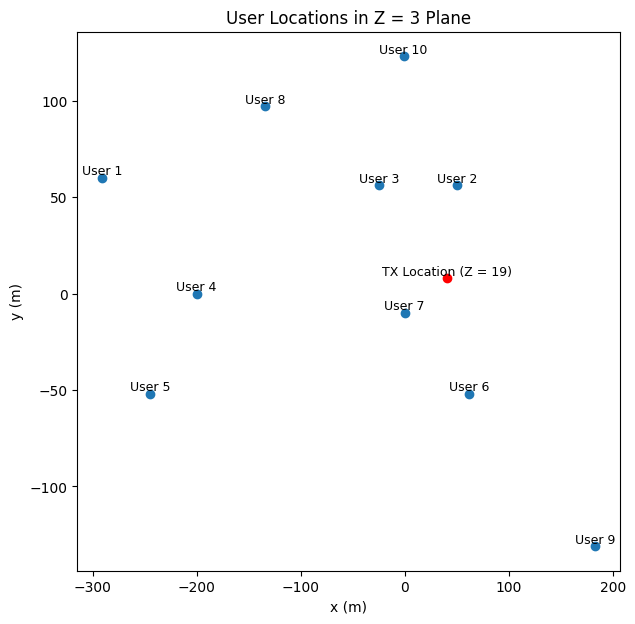

In [6]:
user_positions_3d = np.array(rx_pos)
user_positions_2d = user_positions_3d[:, :2]
plt.figure(figsize = (7,7))
plt.scatter(user_positions_2d[:, 0], user_positions_2d[:, 1])
plt.scatter(TX_LOC[0], TX_LOC[1], c='red')
plt.text(TX_LOC[0], TX_LOC[1], "TX Location (Z = 19)", fontsize = 9, ha = 'center', va = 'bottom')
for i, (x,y) in enumerate(user_positions_2d):
    plt.text(x, y, f"User {i + 1}", fontsize = 9, ha = 'center', va = 'bottom')
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("User Locations in Z = 3 Plane")

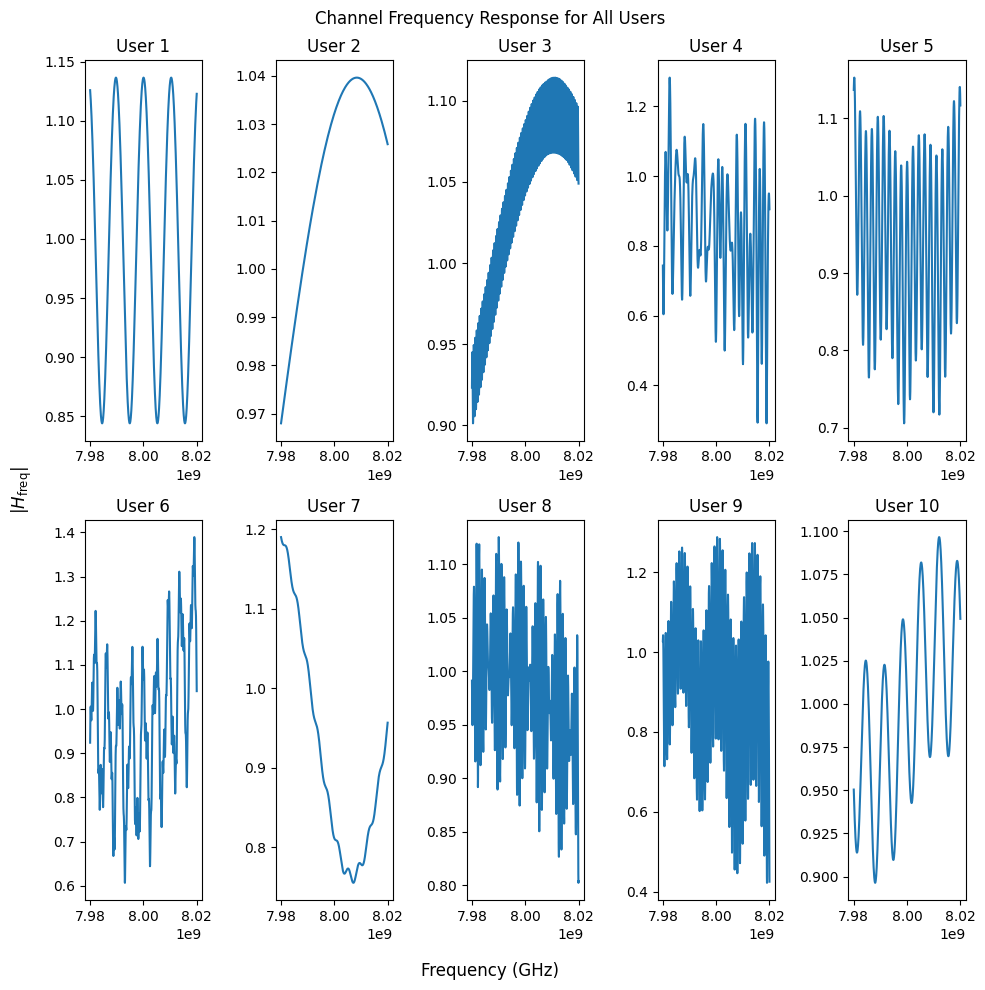

In [7]:
nfreqs = 1000
sweep_freqs = np.linspace(FC-BW, FC+BW, num=nfreqs)
h_freq_sweep = paths.cfr(frequencies=sweep_freqs,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")
abs_h_fs = np.abs(h_freq_sweep)
h_freq_FC = paths.cfr(frequencies=FC,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")
abs_h_fc = np.abs(h_freq_FC)
h_freq = h_freq_FC.reshape(10,50)
abs_h_freq = np.abs(h_freq)
# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]

fig1, axs1 = plt.subplots(2,5, figsize = (10,10))
axs1 = axs1.flatten()

for i, ax in enumerate(axs1):
    ax.plot(sweep_freqs, abs_h_fs[i,0,0,0,0,:])
    ax.set_title(f"User {i + 1}")
    # ax.set_xlabel("Frequency (GHz)")
    # ax.set_ylabel(r"|$h_\text{freq}$|")

fig1.supxlabel("Frequency (GHz)")
fig1.supylabel(r"|$H_\text{freq}$|")
fig1.suptitle("Channel Frequency Response for All Users")
plt.tight_layout()
plt.show()

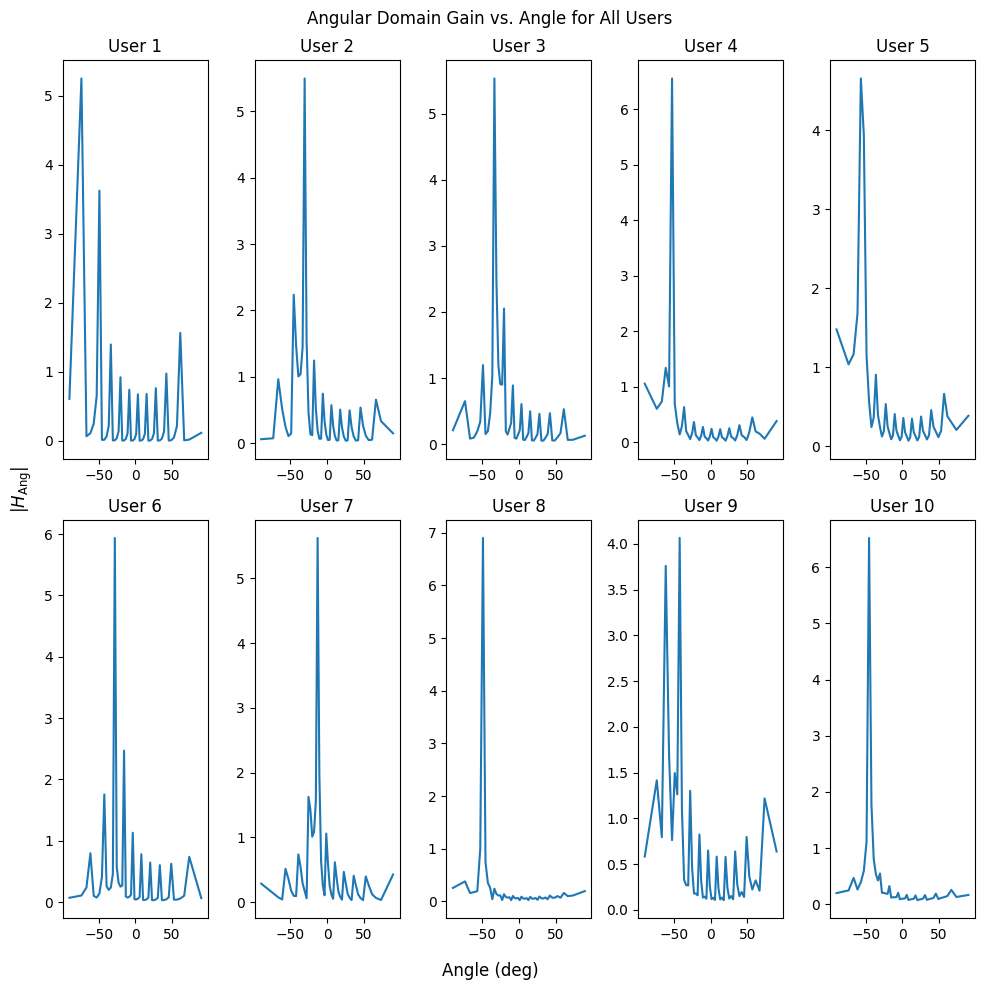

In [8]:
Ut = create_U_P2P(N_TX, D_BY_LAMBDA)
H = h_freq
Ha = h_freq @ Ut
abs_Ha = np.abs(Ha)
# plt.figure(figsize = (10,10))
# for k in range(N_RX):
#     gain = np.abs(Ha)[k]
#     plt.plot(gain, label = f"User {k + 1}")

angs_deg = np.arcsin(np.linspace(-1, 1, N_TX)) * 180 /PI
fig2, axs2 = plt.subplots(2,5, figsize = (10,10))
axs2 = axs2.flatten()

for i, ax in enumerate(axs2):
    ax.plot(angs_deg, abs_Ha[i])
    ax.set_title(f"User {i + 1}")

fig2.supxlabel("Angle (deg)")
fig2.supylabel(r"|$H_\text{Ang}$|")
fig2.suptitle("Angular Domain Gain vs. Angle for All Users")
plt.tight_layout()
plt.show()

In [9]:
W = H.conj().T @ np.linalg.inv(H @ H.conj().T) #unnormalized
W = W / np.linalg.norm(W, 'fro') #total power (frobenius) normalization
Wa = Ha.conj().T @ np.linalg.inv(Ha @ Ha.conj().T) #normalized
Wa =  Wa / np.linalg.norm(Wa, 'fro') #total power (frobenius) normalization
abs_W = np.abs(W)
abs_Wa = np.abs(Wa)
H_ZF = H @ W
Ha_ZF = Ha @ Wa
abs_H_ZF = np.abs(H_ZF)
abs_Ha_ZF = np.abs(Ha_ZF)
print(H_ZF.shape)

(10, 10)


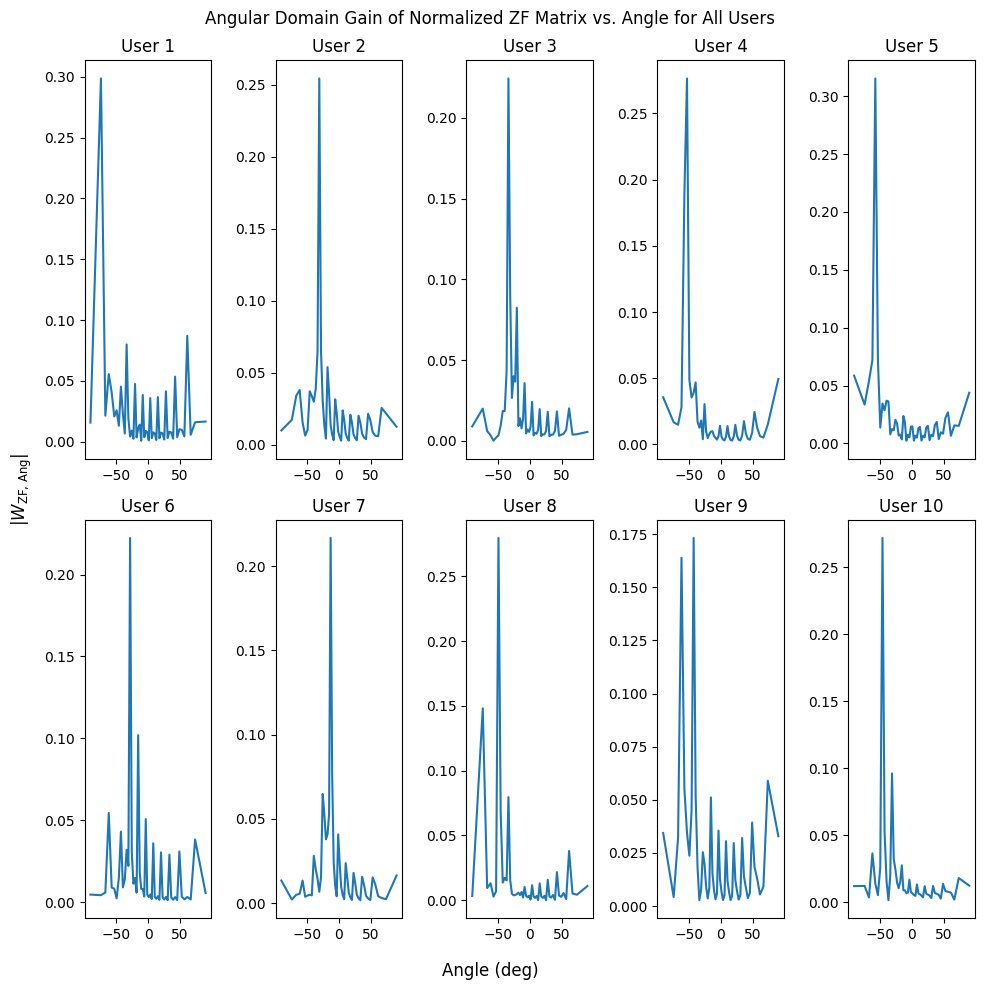

In [10]:
fig3, axs3 = plt.subplots(2,5, figsize = (10,10))
axs3 = axs3.flatten()

for i, ax in enumerate(axs3):
    ax.plot(angs_deg, abs_Wa[:, i], label = f"Wa for User {i}")
    # ax.plot(angs_deg, abs_Ha[i, :], label = f"Ha for User {i}")
    ax.set_title(f"User {i + 1}")
    # ax.legend()

fig3.supxlabel("Angle (deg)")
fig3.supylabel(r"|$W_\text{ZF, Ang}$|")
fig3.suptitle("Angular Domain Gain of Normalized ZF Matrix vs. Angle for All Users")
plt.tight_layout()
plt.show()

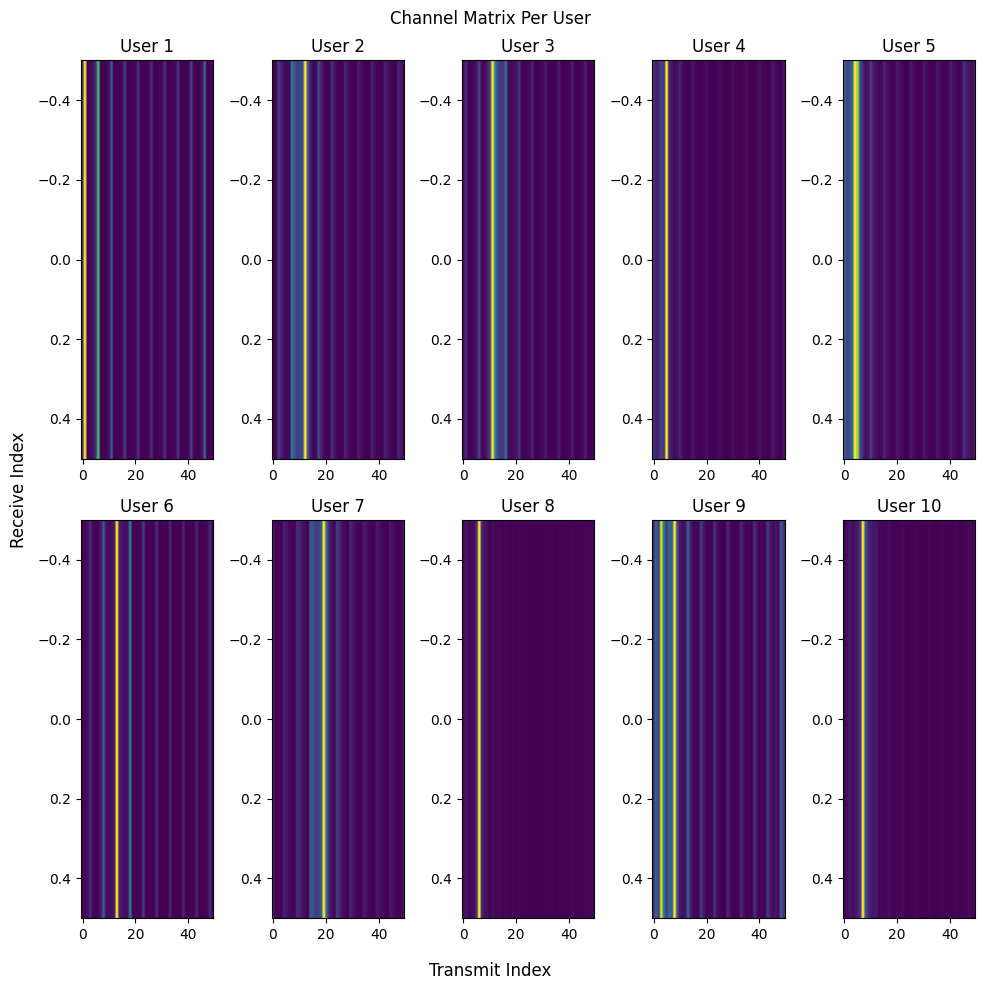

In [11]:
fig4, axs4 = plt.subplots(2,5, figsize = (10,10))
axs4 = axs4.flatten()

for i, ax in enumerate(axs4):
    ax.imshow(abs_Ha[i, :].reshape(50, 1).T, aspect = 'auto')
    ax.set_title(f"User {i + 1}")

fig4.supxlabel("Transmit Index")
fig4.supylabel("Receive Index")
fig4.suptitle("Channel Matrix Per User")
plt.tight_layout()

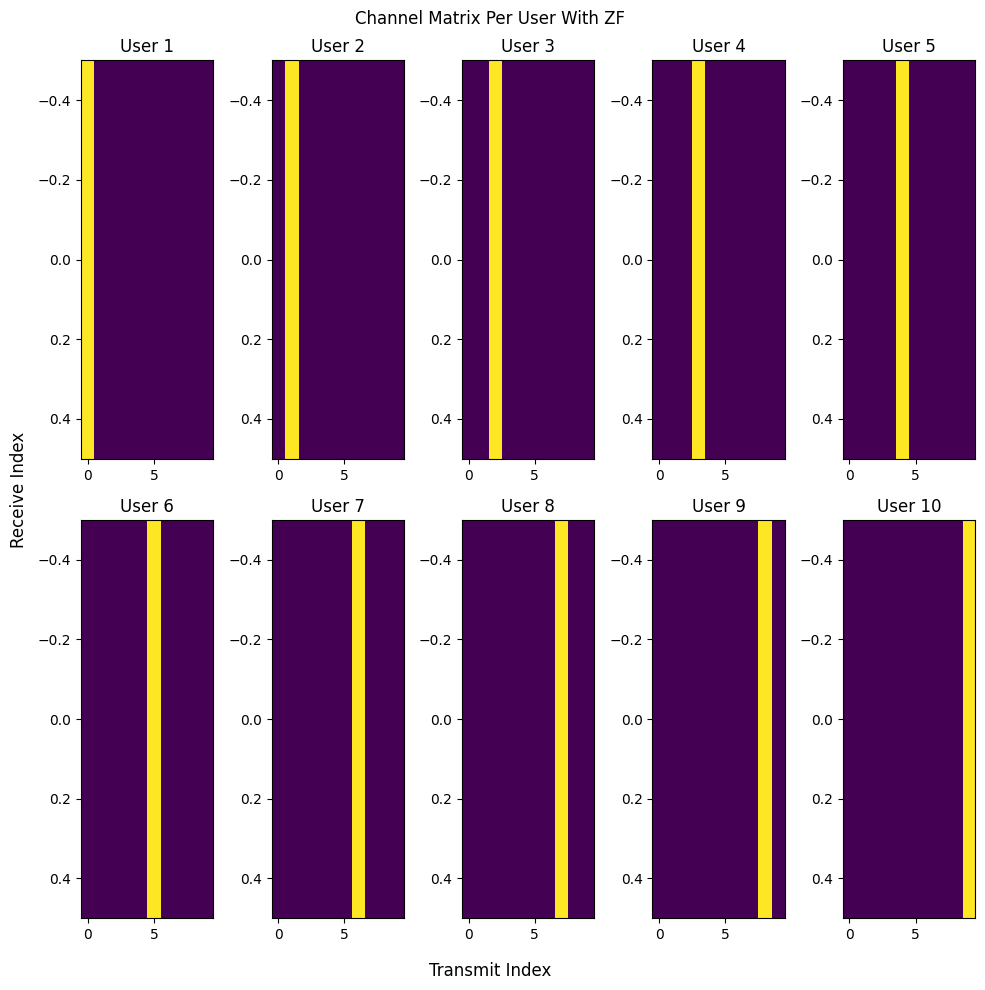

In [12]:
fig5, axs5 = plt.subplots(2,5, figsize = (10,10))
axs5 = axs5.flatten()

for i, ax in enumerate(axs5):
    ax.imshow(abs_Ha_ZF[i, :].reshape(10, 1).T, aspect = 'auto')
    ax.set_title(f"User {i + 1}")

fig5.supxlabel("Transmit Index")
fig5.supylabel("Receive Index")
fig5.suptitle("Channel Matrix Per User With ZF")
plt.tight_layout()

(-1.5, 1.5)

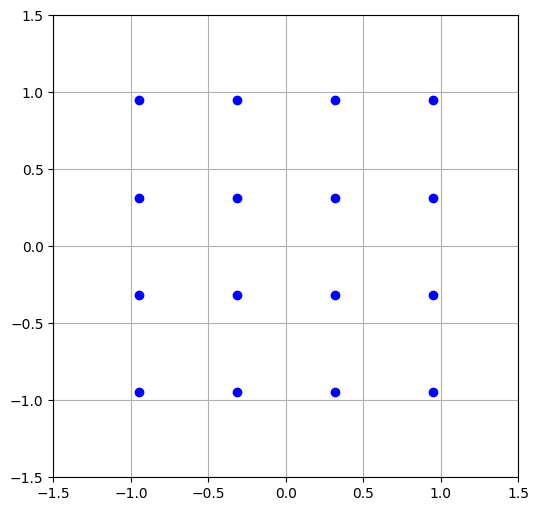

In [13]:
levels = [-3, -1, 1, 3]
constellation = [complex(i, q) for i in levels for q in levels]
qam16_vector = np.array(constellation)

rms = np.sqrt(np.mean(np.abs(qam16_vector)**2))
qam16_normalized = qam16_vector / rms

plt.figure(figsize=(6,6))
plt.plot(qam16_normalized.real, qam16_normalized.imag, 'bo')
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

In [14]:
constellation_power = 1
s = constellation_power * np.random.choice(qam16_normalized, size=(N_RX,))
n = (np.random.randn(N_RX,) + 1j * np.random.randn(N_RX,)) / np.sqrt(2)
p_sig = np.abs(H @ W @ s)**2
p_noise = np.abs(n)**2
mean_p_sig = np.mean(p_sig)
mean_p_noise = np.mean(p_noise)
avg_sinr_per_user = mean_p_sig / mean_p_noise
sinr_per_user = p_sig / p_noise

capacity_total_bpsHz = 0
for n in range(N_RX):
    capacity_total_bpsHz += np.log2(1 + avg_sinr_per_user)

print("Avg. SINR Per User: ", avg_sinr_per_user)
for user, sinr in enumerate(sinr_per_user):
    print(f"User {user + 1} SINR: {sinr}")
print("Capacity (bit/s/Hz) : ", capacity_total_bpsHz)

Avg. SINR Per User:  2.9285260263772233
User 1 SINR: 0.35567381248710944
User 2 SINR: 362.37493492289775
User 3 SINR: 5.63816407315381
User 4 SINR: 11.087353335062819
User 5 SINR: 2.387605904763096
User 6 SINR: 2.326769914951063
User 7 SINR: 5.8420705041668315
User 8 SINR: 1.803848140637316
User 9 SINR: 0.31896427829404234
User 10 SINR: 31.847038652967054
Capacity (bit/s/Hz) :  19.739881182564197


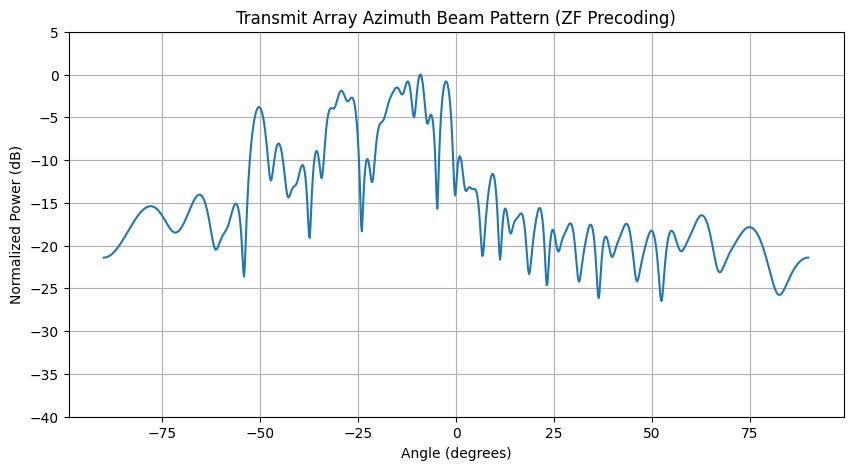

In [15]:
angles = np.linspace(-90, 90, 1000) #azimuth angles in degrees
theta_rad = np.radians(angles)

def steering_vector(theta, N):
    return np.exp(1j * 2 * np.pi * D_BY_LAMBDA * np.arange(N) * np.sin(theta)).reshape(-1, 1)

beam_pattern = []
for theta in theta_rad:
    a = steering_vector(theta, N_TX)
    power = np.linalg.norm(a.conj().T @ W)**2
    beam_pattern.append(power)

beam_pattern = 10 * np.log10(np.abs(beam_pattern) / np.max(beam_pattern))

plt.figure(figsize=(10, 5))
plt.plot(angles, beam_pattern)
plt.grid(True)
plt.title("Transmit Array Azimuth Beam Pattern (ZF Precoding)")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power (dB)")
plt.ylim(-40, 5)
plt.show()

/tmp/ipykernel_6560/1661879280.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beam_patterns[k, idx] = np.abs(a.conj().T @ wk)**2


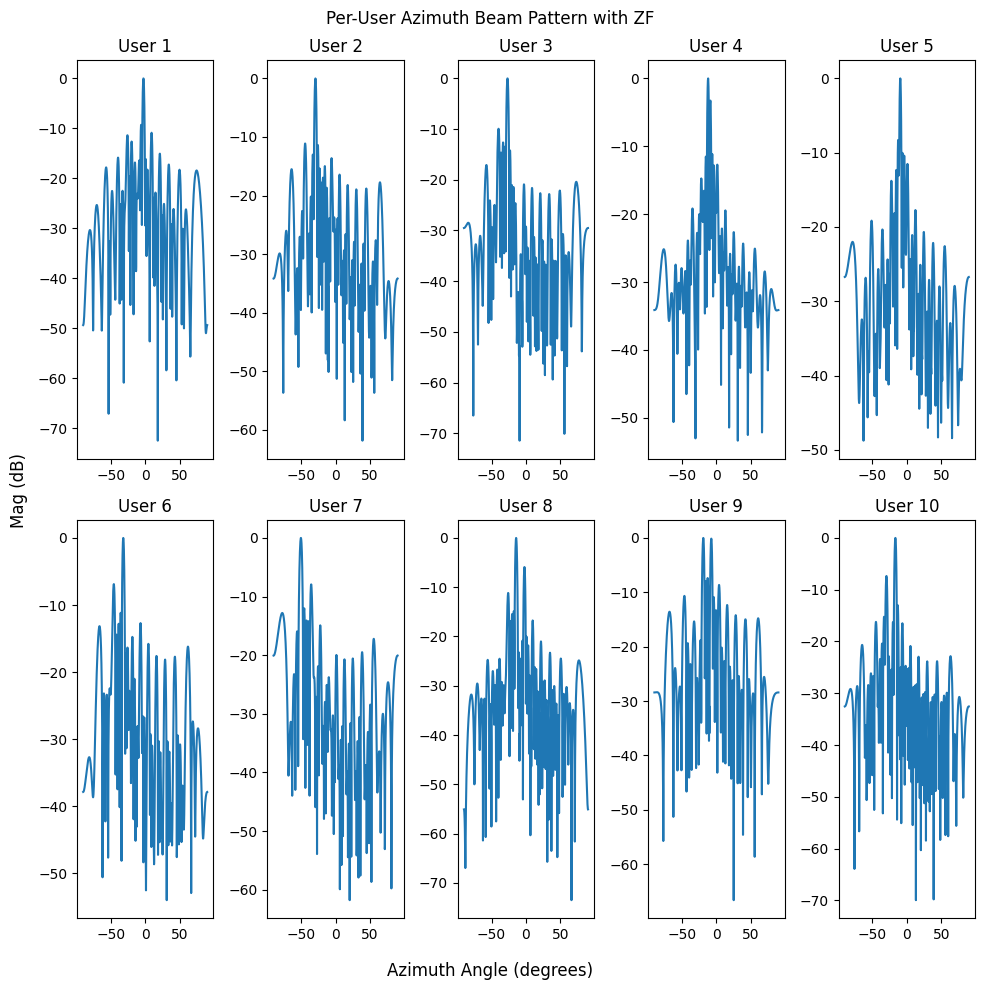

In [16]:
W = H.conj().T @ np.linalg.inv(H @ H.conj().T) #unnormalized
W = W / np.linalg.norm(W, axis=0, keepdims=True)

# Compute beam pattern for each user stream
beam_patterns = np.zeros((N_RX, len(theta_rad)))

for k in range(N_RX):
    wk = W[:, k].reshape(-1, 1)
    for idx, theta in enumerate(theta_rad):
        a = steering_vector(theta, N_TX)
        beam_patterns[k, idx] = np.abs(a.conj().T @ wk)**2

# Normalize per user
beam_patterns_db = 10 * np.log10(beam_patterns / np.max(beam_patterns, axis=1, keepdims=True))

# Plot
# plt.figure(figsize=(12, 6))
# for k in range(N_RX):
#     plt.plot(angles, beam_patterns_db[k], label=f'User {k+1}')

# plt.title("Per-User Beam Patterns (ZF Precoding)")
# plt.xlabel("Angle (degrees)")
# plt.ylabel("Normalized Power (dB)")
# plt.ylim(-40, 5)
# plt.grid(True)
# plt.legend()
# plt.show()

fig6, axs6 = plt.subplots(2,5, figsize = (10,10))
axs6 = axs6.flatten()

for i, ax in enumerate(axs6):
    ax.plot(angles, beam_patterns_db[i])
    ax.set_title(f"User {i + 1}")

fig6.supxlabel("Azimuth Angle (degrees)")
fig6.supylabel("Mag (dB)")
fig6.suptitle("Per-User Azimuth Beam Pattern with ZF")
plt.tight_layout()